### <span style="color:red">Warning: Do not run notebook, certain cells take upwards of 30 minutes to run!!!</span>
# <span style="font-size:1.3em;">Beer Me: A Content-Based Recommender System
Author: Steven Addison

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  
    
- <a href="#Imports">Imports</a> 

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a> 
    
    - <a href="#Creating Final Database">Creating Final Database</a>
    
    - <a href="#Text Preprocessing with Texthero">Text Preprocessing with Texthero</a>    
    
- <a href="#Modeling">Modeling</a>
    
    - <a href="#Cosine Similarity">Cosine Similarity</a>
    
    - <a href="#Linear Kernal">Linear Kernal</a>
    
    - <a href="#K-Nearest Neighbors">K-Nearest Neighbors</a>
        
- <a href="#Conclusion">Conclusion</a>
    
- <a href="#Next Steps">Next Steps</a>
    
- <a href="#Sources">Sources</a>

# <a id="#Overview">Overview</a>

> This project analyzes beer review data of 82,000 unique beers and recommends the top similar styles analyzing Review Text with a tf-idf vectorizer, Style, ABV, and Overall Rating.

# <a id="#Business Understanding">Business Understanding</a>

> As someone who has spent many years in the restaurant industry I often dread hearing “what do you recommend”, it always has felt like a loaded question to me seeing how one never has enough time to learn about a customer’s likes and taste in order to give accurate guidance. That is why a content-based recommender system such as this one can take all the guessing work out of the equation so that a customer can enjoy a beverage that has been selected for them based on similar items other enthusiasts have previously reviewed and enjoyed.

# <a id="Data Understanding">Data Understanding</a>

> For this project I used three datasets sourced from Kaggle that contains information gathered from Beer Advocate. For reproducibility one will have to download the data from the source, as it is too large to host on Github.

# <a id="Imports">Imports</a>

> First, I start with importing the relevant libraries needed to clean my data and create my models.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import texthero as hero
from texthero import preprocessing
from texthero.visualization import wordcloud


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.neighbors import NearestNeighbors



import warnings
warnings.filterwarnings('ignore')

---
# <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

> I wrote a simple function to explore my datasets with that can be found in the `eda.py` file in my repo. This function will display the first five rows of the dataframe, counts of the non-null values, data types, and total entires, check the descriptive statistics, value counts of every column, and print off the sum of any null values. This function is commented out in the notebook for brevity's sake, but can be accessed if cloned to your local machine. 

In [1]:
# import script used to preform basic EDA on my datasets, plus a dictionary used to define a later column
%run eda.py

Exception: File `'eda.py'` not found.

---
> ### First Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> This csv contains information about every beer on an individual level. Features such as `style`, `abv`, and `availability` will be used in the modeling process.

In [3]:
# Reading in the data containing the beers
beer = pd.read_csv('data/beers.csv')

In [4]:
# EDA on that data
# eda(beer)

In [5]:
# Dropping irrelevant columns
beer = beer.drop(columns=['country','notes'])

# Renaming columns for consistency among all dataframes
beer = beer.rename(columns={'id': 'beer_id', 'name': 'beer_name'})

# Removing rows without state data
beer = beer.dropna(subset=['state'])

# Cleaning the availability column 
beer['availability'] = beer['availability'].str.strip()

In [6]:
# Using the style dictionary to create the broad style column
beer['broad_style'] = beer['style'].replace(styledict)

---
> ### Second Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> Here we find information about the breweries. No data here will be used for modeling, however data about `state`,`city`, and `brewery_name` will be important elements to present in my results.

In [8]:
# Reading in the data containing the breweries
breweries = pd.read_csv('data/breweries.csv')

In [9]:
# EDA on that data
# eda(breweries)

In [10]:
# Dropping irrelevant columns
breweries = breweries.drop(columns=['notes'])

# Renaming columns for consistency among all dataframes
breweries = breweries.rename(columns={'id': 'brewery_id', 'name': 'brewery_name'})

# Removing rows without state data
beer = beer.dropna(subset=['state'])

---
> ### Third Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> Finally, I load in my review data. This will provide my most important modeling feature.

In [11]:
# Reading in the data containg the breweries
reviews = pd.read_csv('data/reviews.csv')

In [12]:
# EDA on that data
# eda(reviews)

In [13]:
# Dropping irrelevant columns
reviews = reviews.drop(columns=['date','look','smell','taste','feel','overall'])

# Setting blank reviews as nan so they can be dropped
reviews['text'] = reviews['text'].str.strip()
reviews['text'] = reviews['text'].replace({"":np.nan,"0%":np.nan})

# Dropping reviews without username and review text data
reviews = reviews.dropna(subset=['username','text'])

---

## <a id="#Creating Final Database">Creating Final Database</a>
> Now that all my data is loaded and cleaned, it can be combined. Using `id` columns provided in each dataframe this does not prove to be too much of a hassle. Once merged I can then group every unique beer and conglomerate all of their reviews into individual documents. 

In [14]:
# Merging reviews into the beers bases on beer id
beer_reviews = beer.merge(reviews, on=['beer_id'])

In [15]:
# Merging breweries into the combined data
plus_brew = beer_reviews.merge(breweries, on=['brewery_id'])

In [16]:
# Dropping duplicate column
plus_brew = plus_brew.drop(columns=['state_x'])

# Renaming column to reflect
plus_brew = plus_brew.rename(columns={'state_y': 'state'})

In [17]:
# Selecting only available US beers
df = plus_brew.loc[(plus_brew['country'] == 'US') & (plus_brew['retired'] == 'f')]

# Dropping duplicates
df = df.drop_duplicates()

# Dropping rows with missing ibu data 
df = df.dropna(subset=['abv'])

# Sanity check of the data
df.head()

,beer_id,beer_name,brewery_id,style,availability,abv,retired,broad_style,username,text,score,brewery_name,city,state,country,types
0,246438,Peaches-N-Cream,44617,American Cream Ale,Rotating,5.1,f,Cream Ale,rolltide8425,Exactly what it says it is,3.67,Mad Princes Brewing,Doylestown,PA,US,"Brewery, Bar, Beer-to-go"
307,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,DrMullet,Pours a very dark brown with moderate head and...,3.50,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"
308,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,Karibourgeois,Dark brown pour with a tan head. Aroma of choc...,3.44,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"
309,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,Jeffsta1,"Beautiful dark brown/black, with a pretty, pal...",3.44,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"
310,12661,Lava Rock Porter,1345,American Porter,Year-round,7.0,f,Porter,harrymel,Reviewed 06/23/10 poured from bottle to new be...,3.82,Dick's Brewing Company,Centralia,WA,US,"Brewery, Bar, Eatery"


In [18]:
# Checking to see if some of these beers are actually named IPA and looking at each brewery's website I can confirm they are not creative people
df.loc[df['beer_name'] == 'IPA']

,beer_id,beer_name,brewery_id,style,availability,abv,retired,broad_style,username,text,score,brewery_name,city,state,country,types
87954,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,mjbachma,"Classic bottle and labeling, titled by style, ...",3.94,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87955,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,CraftBeerRunner,Sweet Jammy fruity and bright. Drank fresh whi...,4.00,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87956,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,Hopheadjeffery,Tasted in a Spiegelau IPA glass from a bottle ...,4.04,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87957,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,BeerAndGasMasks,"From the bottle, it pours a nice lightly hazy ...",4.00,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87958,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,NickSMpls,Can these guys do anything that's not great? O...,4.18,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002145,202279,IPA,24952,American IPA,Rotating,6.5,f,India Pale Ale,kojevergas,On-draught at the bar in Sonoma. $5 per 16 oz ...,2.82,Hopmonk Tavern,Sonoma,CA,US,"Brewery, Bar, Eatery"
2002153,349972,IPA,49155,American IPA,Year-round,6.5,f,India Pale Ale,brett808ola,"Smells very fruity, great for tropical weather...",4.98,Hawaiian Ola Brewing Corporation,Kailua Kona,HI,US,"Brewery, Bar, Beer-to-go"
2002260,275547,IPA,48593,American IPA,Year-round,6.6,f,India Pale Ale,JacobusFavier23,L- Straw colored IPA with a slight amber tint....,3.66,Haint Blue Brewery,Mobile,AL,US,Brewery
2002326,322903,IPA,47202,American IPA,Year-round,5.9,f,India Pale Ale,stevoj,Bottle from BevMo. Gusher at opening. Dark gol...,3.55,Dagny Brewing Company,Modesto,CA,US,Brewery


In [20]:
# Creating a dataframe grouped by beer for content-based recommendations
cont_df = df.groupby(['beer_id'], as_index = False).agg({'text':' '.join, 'score':'mean','beer_id':'first',
                                                         'beer_name':'first','style':'first','broad_style':'first',
                                                         'abv':'first','brewery_name':'first','city':'first',
                                                         'state':'first'})

# Setting the index to beer's unique ID
cont_df = cont_df.set_index('beer_id')

# Sanity check of the data
cont_df.head()

,text,score,beer_name,style,broad_style,abv,brewery_name,city,state
beer_id,,,,,,,,,
5,Beautiful beer. Light and tasty. I travel all ...,3.396390,Amber,Vienna Lager,Dark Lager,4.5,Abita Brewing Co.,Abita Springs,LA
6,great brown ale...one of my favorites. Might h...,3.646446,Turbodog,English Brown Ale,Brown Ale,5.6,Abita Brewing Co.,Abita Springs,LA
7,The labeling with the purple haze guy with the...,3.243842,Purple Haze,Fruit and Field Beer,Fruit and Field Beer,4.2,Abita Brewing Co.,Abita Springs,LA
9,Poured chilled in large glass stein. A: cloudy...,3.087823,Golden,American Lager,Pale Lager,4.2,Abita Brewing Co.,Abita Springs,LA
10,Pours slightly hazy deep amber/brown. 1 finger...,3.794484,Dubbel Ale,Belgian Dubbel,Dark Ale,7.0,Allagash Brewing Company,Portland,ME


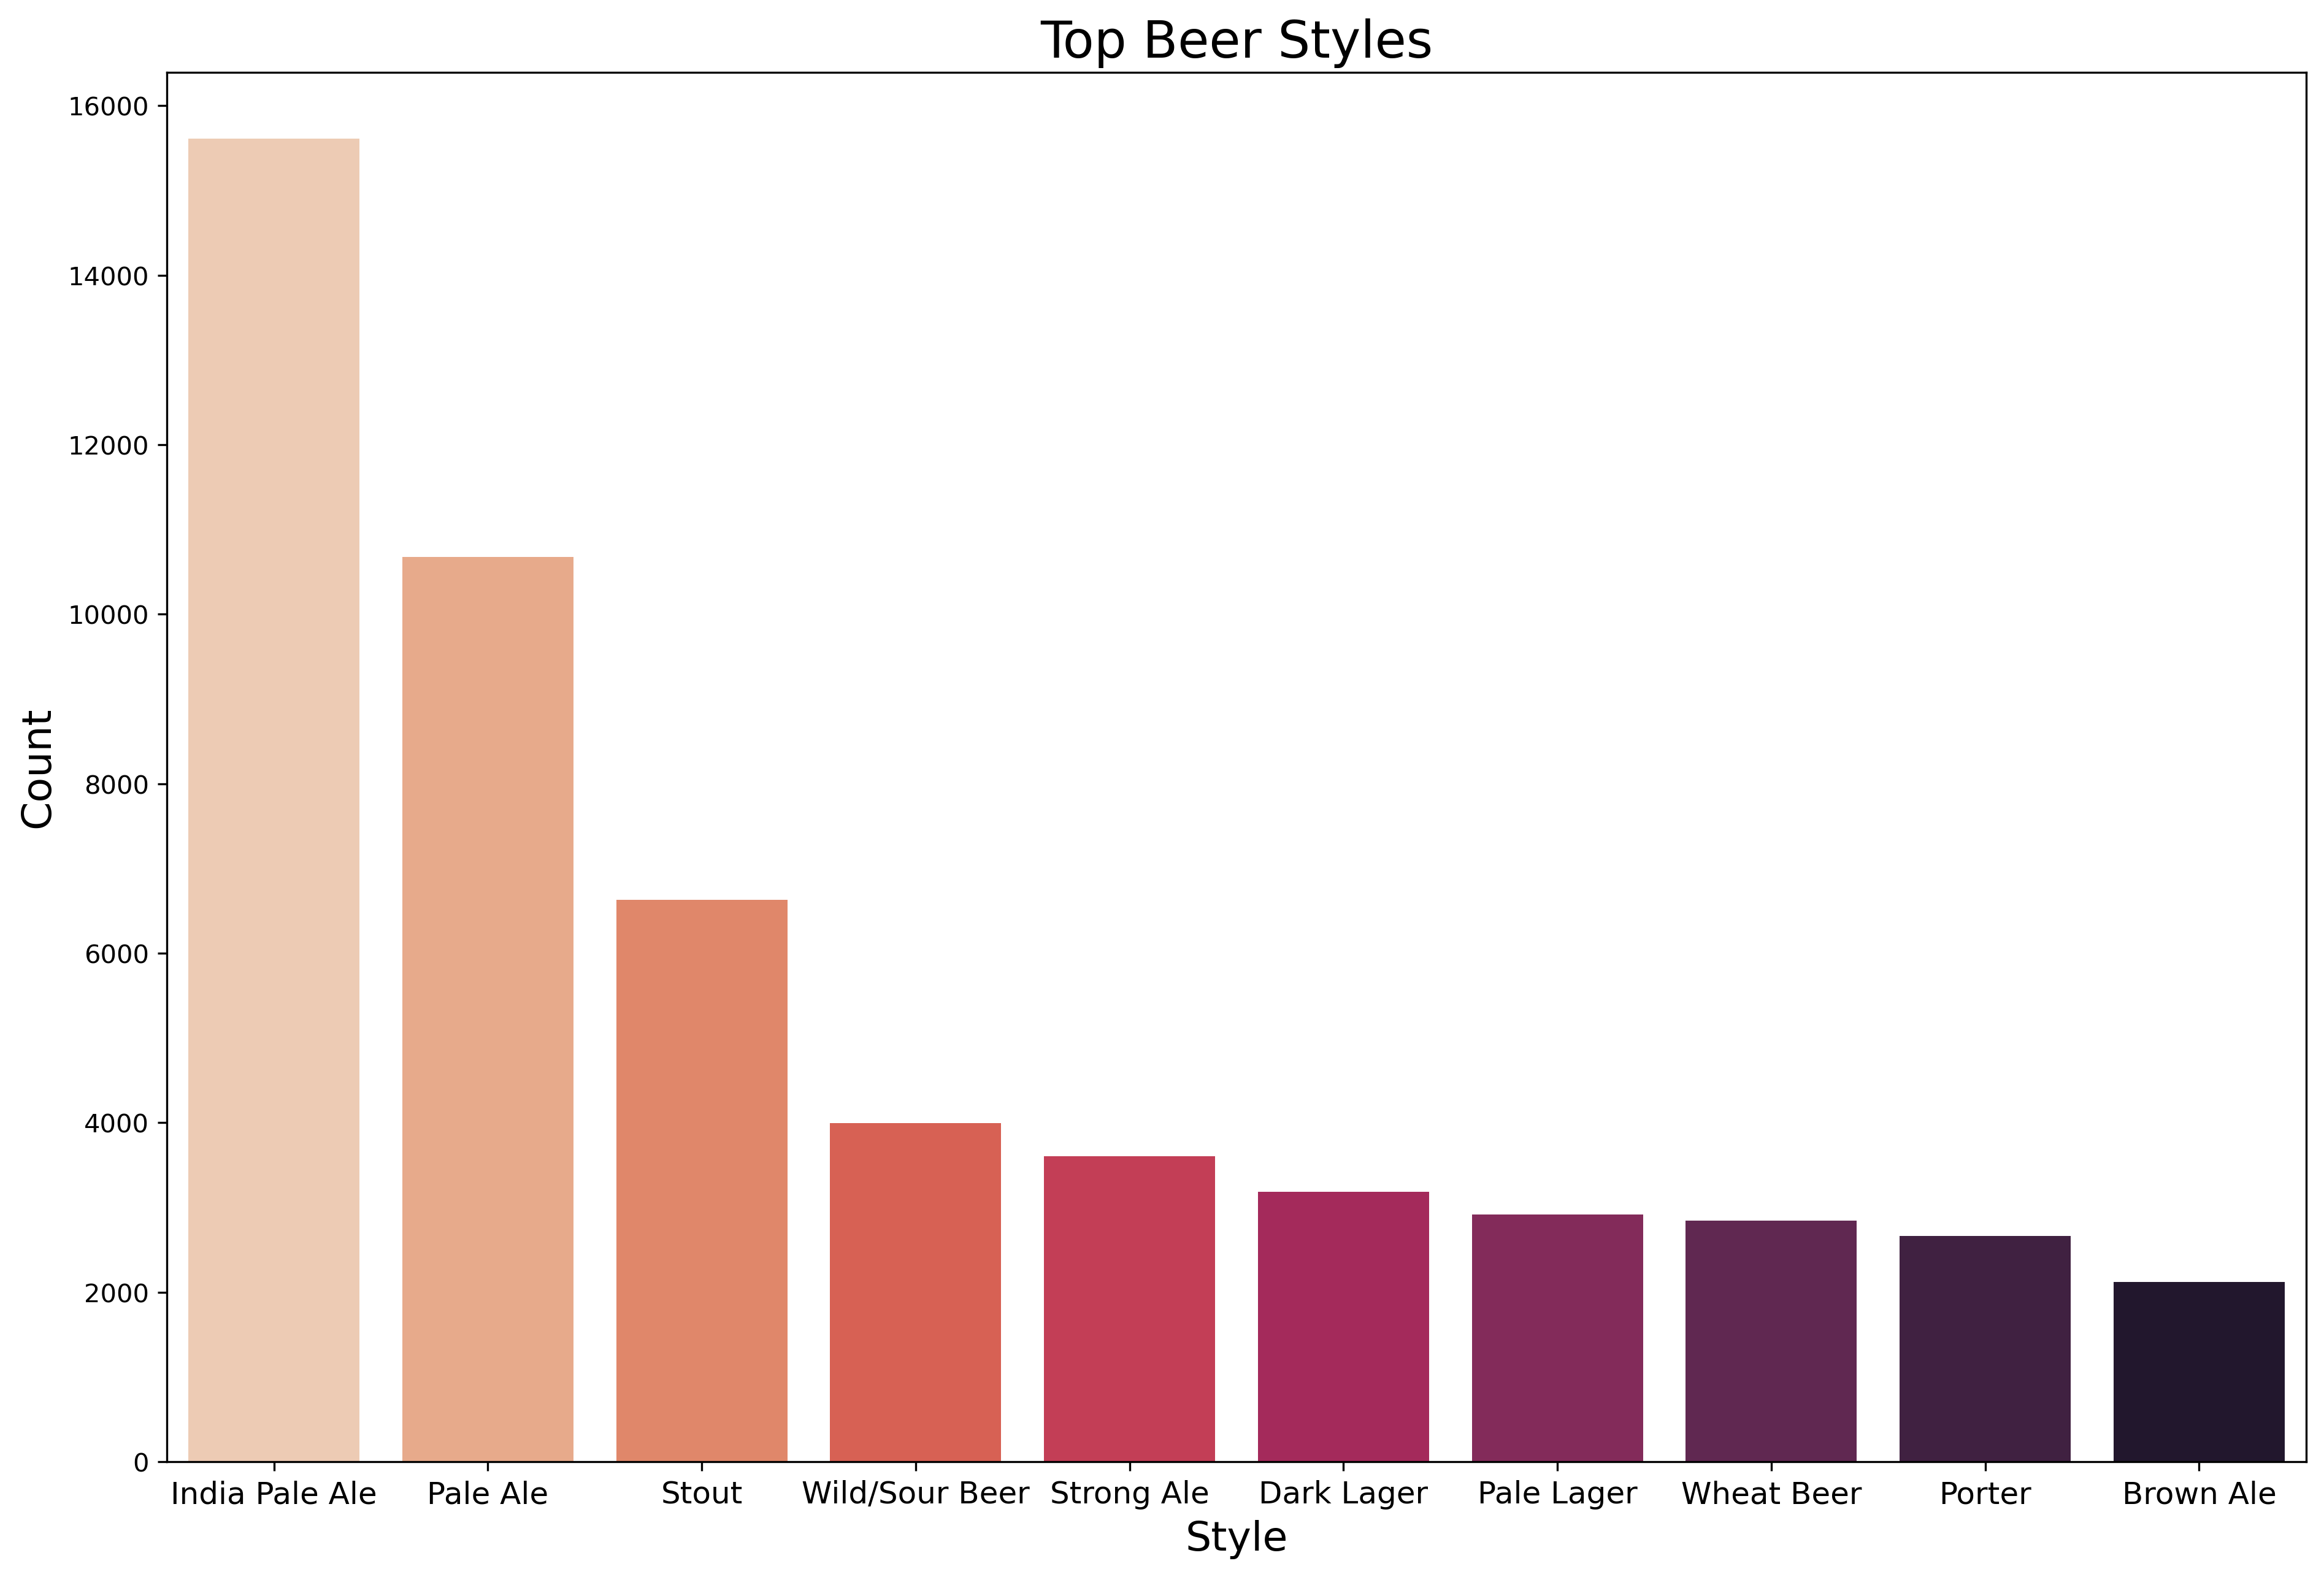

In [37]:
# Plotting the top ten styles
plt.figure(figsize=(15,10), dpi=300)
ax = sns.countplot(x = 'broad_style', data=cont_df, palette='rocket_r', 
                   order=cont_df['broad_style'].value_counts().index[:10])
plt.title("Top Beer Styles", fontsize=20)
plt.xlabel("Style", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12);

## <a id="#Text Preprocessing with Texthero">Text Preprocessing with Texthero</a> 

> Knowing I wanted to use NLP in my project, I set out to do some research. After reading [several](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db)[different](https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272)[articles](https://elitedatascience.com/python-nlp-libraries) on how to clean and analyze text data I decided to use [Texthero](https://texthero.org/) for my review preprocessing. Combining elements of spaCy and NLTK, along with its simple to use all-in-one cleaning pipeline, it provided to be the most logical choice of tool. [documentation](https://texthero.org/docs/api-preprocessing) can be found here.

In [ ]:
# Using Texthero's built in text cleaning pipeline
cont_df['clean_text'] = hero.clean(cont_df['text'])

In [ ]:
# Stemming the text for modeling
cont_df['clean_text'] = hero.stem(cont_df['clean_text'])

In [ ]:
# Dropping irelevant columns 
cont_df = cont_df.drop(columns=['text'])

In [ ]:
# Sanity check of the data
cont_df.head()

In [ ]:
# Saving off final cleaned dataset for use in the Streamlit App
# cont_df.to_csv('data/cont_df.csv', index_label = 'beer_id')

In [ ]:
# Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))

# Fitting and transforming the clean text data 
dtm = tf.fit_transform(cont_df['clean_text'])

# Creating a document-term matrix
dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = cont_df.index)

In [ ]:
# Sanity check of the data
dtm.head()

# <a href="#Modeling">Modeling</a>
> To model this data I start with 

In [ ]:
# Merging the document-term matrix back into the content dataframe
model_df = cont_df.merge(dtm, left_index=True, right_index=True)

# Renaming columns with the same name
model_df = model_df.rename(columns={'style_x':'style','abv_x':'abv'})

# Dropping irrelevant columns
model_df = model_df.drop(columns=['beer_id','style','beer_name','brewery_name','city','state','clean_text'])

In [ ]:
# Creating a dataframe to call my results from
result_df = cont_df[['beer_name','style','brewery_name','city','state']]

# Making the column names pretty
result_df = result_df.rename(columns={'beer_name':'Name','style':'Style',
                                      'brewery_name':'Brewery','city':'City',
                                      'state':'State'})

In [ ]:
# Encoding the styles for modeling
style_OHE = pd.get_dummies(model_df['broad_style'], sparse=True)

In [ ]:
# Calling the columns that need to be scaled
col_names = ['abv', 'score']

# Selecting those columns
features = model_df[col_names]

# Fitting and transforming the columns with a MinMaxScalers
features = MinMaxScaler().fit_transform(features.values)

# Setting those transformed features back into the data
model_df[col_names] = features

# Joining the one hot encoded data with the scaled data
final_df = model_df.join(style_OHE)

# Dropping the style column now that it is encoded out
final_df = final_df.drop(columns=['broad_style'])

In [ ]:
# Sanity check
final_df.head()

In [ ]:
# Superfuzz is the beer I will be testing
y = np.array(final_df.loc[90993])

# Reshaping the row into an array that can be passed into the model
y = y.reshape(1, -1)

# Calculating the cosine similarity 
cos_sim = cosine_similarity(final_df, y)

# Creating a printout of the scores with their respective indices
cos_sim = pd.DataFrame(data=cos_sim, index=final_df.index)

# Sorting by highest scoring
results = cos_sim.sort_values(by = 0, ascending=False)

# Printing out the source beer and its top 5 recommendations
results.head(6)

In [ ]:
# This is the printout for my starting beer
result_df.loc[90993]

In [ ]:
# And the printout of my top result
result_df.loc[80348]

## <a id="#Cosine Similarity">Cosine Similarity</a>

In [ ]:
def cos_beer():
    
    """Returns top recommended beers based on cosine similarity with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    y = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    y = y.reshape(1, -1)
    
    # Calculating the cosine similarity 
    cos_sim = cosine_similarity(style_df, y)
    # Creating a printout of the scores with their respective indices
    cos_sim = pd.DataFrame(data=cos_sim, index=style_df.index)
    # Sorting by highest scoring
    results = cos_sim.sort_values(by = 0, ascending=False)
    # Selecting n number indicies of top recommendations
    nresultsid = results.head(n_recs+1).index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[nresultsid]
    # Returning those results
    return nresults_df.style.hide_index()

In [ ]:
# Testing the function
cos_beer()

## <a id="#Linear Kernal">Linear Kernal</a>

In [ ]:
def lin_beer():
    
    """Returns top recommended beers based on linear kernel with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    y = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    y = y.reshape(1, -1)
    
    # Calculating the linear kernel 
    lin_ker = linear_kernel(style_df, y)
    # Creating a printout of the scores with their respective indices
    lin_ker = pd.DataFrame(data=lin_ker, index=style_df.index)
    # Sorting by highest scoring
    results = lin_ker.sort_values(by = 0, ascending=False)
    # Selecting n number indicies of top recommendations
    nresultsid = results.head(n_recs+1).index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[nresultsid]
    # Returning those results
    return nresults_df.style.hide_index()

In [ ]:
# Testing the function
lin_beer()

## <a id="#K-Nearest Neighbors">K-Nearest Neighbors</a>

In [ ]:
def knn_beer():
    
    """Returns top recommended beers using K-Nearest Neighbors with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    x = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    x = y.reshape(1, -1)
    
    # Creating a knn model with the auto algorithm and 5 nearest neighbors
    knn = NearestNeighbors(algorithm='auto', n_neighbors=5)
    # Fitting the model on the dataframe
    knn.fit(style_df)
    
    # Selecting n number results
    results = knn.kneighbors(x, n_recs+1, return_distance=False).flatten()
    # Selecting their indicies
    resultsids = style_df.iloc[results].index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[resultsids]
    # Returning those results
    return nresults_df.style.hide_index()

In [ ]:
# Testing the function
knn_beer()

# <a id="#Conclusion">Conclusion</a>

>

In [ ]:
# Importing mask for the shape of my word clouds
beer_mask = np.array(Image.open('images/beershape.png'))

In [ ]:
# Creating cloud for my reference beer
beer1 = cont_df.loc[[90993]]['clean_text']
wordcloud(beer1, max_words = 50, mask=beer_mask, contour_color='#802036', contour_width=2, colormap = 'flare', height= 600)

In [ ]:
# Creating cloud for my top recommendation
beer2 = cont_df.loc[[175577]]['clean_text']
wordcloud(beer2, max_words = 50, mask=beer_mask, contour_color='#802036', contour_width=2, colormap = 'flare', height= 600)

# <a id="#Next Steps">Next Steps</a>   

> As extensive as this may seem, there is always more data that can be gathered. Ideally I would like to get more current data for as many beers as possible to keep the model as up to date as possible. I would also be interested in gathering more features to use such as IBU, and the varieties of hops and malts used to brew each beer. In addition to that, I would like to create more specific data slicing options in the app such as being able to get recommendations based on state or even a brewery level. Lastly I would want to implement this model for other consumables such as whole bean coffee or wine, if you can reviewed it ,I can use it.

# <a id="#Sources">Sources</a>

> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
>[How to Vectorize Text in DataFrames for NLP Tasks — 3 Simple Techniques](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db)
>
> [Try TextHero: The Absolute Simplest way to Clean and Analyze Text in Pandas](https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272)
>
> [5 Heroic Python NLP Libraries](https://elitedatascience.com/python-nlp-libraries)
>
> [Texthero](https://texthero.org/)
>
> [How to Create Beautiful Word Clouds in Python](https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214)